## Import Libraries

In [1]:
import math
import numpy as np
import pandas as pd
from typing import Dict, List

# Not sure if these are available
import copy
import collections 
from collections import defaultdict
import random

# Not available in the competition but necessary for our current moment
from pathlib import Path
from decouple import config
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import os
import re

#from datamodel import OrderDepth, TradingState, Order

## Data Engineering

In [2]:
# Hard code all columns for ease of data engineering
quotes_all_cols = ['day', 'timestamp', 'product', 'bid_price_1', 'ask_price_1', 'bid_price_2', 'ask_price_2', 'bid_price_3', 'ask_price_3', \
                   'bid_volume_1', 'ask_volume_1', 'bid_volume_2', 'ask_volume_2', 'bid_volume_3', 'ask_volume_3', 'mid_price', 'profit_and_loss']

trades_all_cols =  ['timestamp', 'buyer', 'seller', 'symbol', 'currency', 'price', 'quantity']

# Hard code columns to change from string to float
quotes_num_cols = ['timestamp', 'bid_price_1', 'ask_price_1', 'bid_price_2', 'ask_price_2', 'bid_price_3', 'ask_price_3', \
                   'bid_volume_1', 'ask_volume_1', 'bid_volume_2', 'ask_volume_2', 'bid_volume_3', 'ask_volume_3', 'mid_price']
trades_num_cols = ['timestamp', 'price', 'quantity']


### Combine days in a dictionary for processing

In [3]:
# Specify file paths for quotes and trades
BASE_DIR = Path("./data-2024")
DATA_DIR = config('DATA_DIR', default=(BASE_DIR / 'round-1-island-data-bottle'), cast=Path)

# Create a regex to read the prices and trades in a systematic way 
pattern = r'day_(-?\d+)(?:_nn)?\.csv$' 

files_combined = os.listdir(DATA_DIR)
files_quotes = [file for file in files_combined if file.startswith('prices') and file.endswith('.csv')]
files_trades = [file for file in files_combined if file.startswith('trades') and file.endswith('.csv')]

dataframes_quotes = {}
dataframes_trades = {}
for file in files_combined:
# Extract the day number from the file name using regex
    match = re.search(pattern, file)
    if match:
        day_number = int(match.group(1))
        # Read the CSV file into a DataFrame
        if file in files_quotes:
            print(f'{file} added ')
            dataframes_quotes[day_number] = pd.read_csv(os.path.join(DATA_DIR, file))
        elif file in files_trades:
            print(f'{file} added ')
            dataframes_trades[day_number] = pd.read_csv(os.path.join(DATA_DIR, file))

# Sort dataframes_quotes based on keys in ascending order
dataframes_quotes = dict(sorted(dataframes_quotes.items()))

# Sort dataframes_trades based on keys in ascending order
dataframes_trades = dict(sorted(dataframes_trades.items()))

# Combine sorted quotes and trades dataframes into a single list
quotes_trades_comb_list = [dataframes_quotes, dataframes_trades]


trades_round_1_day_-2_nn.csv added 
prices_round_1_day_-2.csv added 
prices_round_1_day_-1.csv added 
trades_round_1_day_0_nn.csv added 
trades_round_1_day_-1_nn.csv added 
prices_round_1_day_0.csv added 


### Create a unique timestamp for each day for analysis

In [4]:
import pandas as pd

def generate_new_timestamp(day, timestamp):
    if day == 0:
        return timestamp  # For day 0, keep the original timestamp
    else:
        return day * 1000000 + timestamp

def append_daily_data(previous_data, daily_dataframe, day):
    new_data = {}

    # Generate new timestamps for each row in the daily dataframe
    for index, row in daily_dataframe.iterrows():
        timestamp = row['timestamp']
        new_timestamp = generate_new_timestamp(day, timestamp)
        
        # Copy all columns from the daily dataframe to the new data dictionary
        row_values = row.to_dict()
        
        # Update the timestamp with the new one
        row_values['timestamp'] = new_timestamp
        
        # Add the row values to the new data
        new_data[index] = row_values
    
    # Convert new data to DataFrame
    new_dataframe = pd.DataFrame.from_dict(new_data, orient='index')
    
    # Append the new DataFrame to the previous data DataFrame
    updated_data = pd.concat([previous_data, new_dataframe], ignore_index=True)
    
    return updated_data


In [5]:
# Create empty DataFrame to start with
previous_quotes = pd.DataFrame(columns=quotes_all_cols)
previous_trades = pd.DataFrame(columns=trades_all_cols)

for x in range(len(quotes_trades_comb_list)):
    for day, df in quotes_trades_comb_list[x].items():
        df_columns = df.columns[0].split(';')
        df = df[df.columns[0]].str.split(';', expand=True)
        df.columns = df_columns
        
        if x == 0:
            df[quotes_num_cols] = df[quotes_num_cols].replace('', '0').astype(float)
            updated_quotes = append_daily_data(previous_quotes, df, day)
            previous_quotes = updated_quotes
        
        elif x == 1:
            df[trades_num_cols] = df[trades_num_cols].replace('', '0').astype(float)
            updated_trades = append_daily_data(previous_trades, df, day)
            previous_trades = updated_trades
        
print(f'Quote Shape: {updated_quotes.shape}')
print(f'Trades Shape: {updated_trades.shape}')

/var/folders/wy/b4nfg57568s0n7t4hpfk3tg00000gn/T/ipykernel_60482/1026663374.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  updated_data = pd.concat([previous_data, new_dataframe], ignore_index=True)
/var/folders/wy/b4nfg57568s0n7t4hpfk3tg00000gn/T/ipykernel_60482/1026663374.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  updated_data = pd.concat([previous_data, new_dataframe], ignore_index=True)


Quote Shape: (60000, 17)
Trades Shape: (16150, 7)


In [6]:
updated_quotes.head()

,day,timestamp,product,bid_price_1,ask_price_1,bid_price_2,ask_price_2,bid_price_3,ask_price_3,bid_volume_1,ask_volume_1,bid_volume_2,ask_volume_2,bid_volume_3,ask_volume_3,mid_price,profit_and_loss
0,-2,-2000000.0,AMETHYSTS,9996.0,10004.0,9995.0,10005.0,0.0,0.0,1.0,1.0,25.0,25.0,0.0,0.0,10000.0,0.0
1,-2,-2000000.0,STARFRUIT,4997.0,5003.0,0.0,0.0,0.0,0.0,26.0,26.0,0.0,0.0,0.0,0.0,5000.0,0.0
2,-2,-1999900.0,AMETHYSTS,10000.0,10005.0,9995.0,0.0,0.0,0.0,5.0,20.0,20.0,0.0,0.0,0.0,10002.5,0.0
3,-2,-1999900.0,STARFRUIT,5000.0,5004.0,4998.0,0.0,4997.0,0.0,5.0,20.0,6.0,0.0,20.0,0.0,5002.0,0.0
4,-2,-1999800.0,STARFRUIT,4997.0,5003.0,4996.0,0.0,0.0,0.0,1.0,31.0,30.0,0.0,0.0,0.0,5000.0,0.0


In [7]:
updated_trades.head()

,timestamp,buyer,seller,symbol,currency,price,quantity
0,-2000000.0,,,AMETHYSTS,SEASHELLS,9996.0,1.0
1,-2000000.0,,,STARFRUIT,SEASHELLS,5003.0,1.0
2,-2000000.0,,,AMETHYSTS,SEASHELLS,9996.0,1.0
3,-1999900.0,,,STARFRUIT,SEASHELLS,5004.0,6.0
4,-1999100.0,,,STARFRUIT,SEASHELLS,5001.0,2.0


### Drop unused columns - specific to this test set

In [8]:
updated_quotes.drop(columns = ['day', 'profit_and_loss'], inplace=True)
updated_trades.drop(columns = ['buyer', 'seller'], inplace=True)

### Create multi-index for Product and Timestamp - Change the names to quotes and trades

In [9]:
quotes = updated_quotes.sort_values(by = ['product','timestamp'])
quotes.set_index(['product', 'timestamp'], inplace=True)

trades = updated_trades.sort_values(by = ['symbol','timestamp'])
trades.set_index(['symbol', 'timestamp'], inplace=True)

quotes_products = list(quotes.index.get_level_values(level=0).unique())
trades_symbols = list(trades.index.get_level_values(level=0).unique())


print(f'Quotes levels: {quotes_products}')
print(f'Trades levels: {trades_symbols}')

Quotes levels: ['AMETHYSTS', 'STARFRUIT']
Trades levels: ['AMETHYSTS', 'STARFRUIT']


In [10]:
# Check a product as an example in trades
quotes.loc['AMETHYSTS']

,bid_price_1,ask_price_1,bid_price_2,ask_price_2,bid_price_3,ask_price_3,bid_volume_1,ask_volume_1,bid_volume_2,ask_volume_2,bid_volume_3,ask_volume_3,mid_price
timestamp,,,,,,,,,,,,,
-2000000.0,9996.0,10004.0,9995.0,10005.0,0.0,0.0,1.0,1.0,25.0,25.0,0.0,0.0,10000.0
-1999900.0,10000.0,10005.0,9995.0,0.0,0.0,0.0,5.0,20.0,20.0,0.0,0.0,0.0,10002.5
-1999800.0,9996.0,10004.0,9995.0,10005.0,0.0,0.0,1.0,1.0,30.0,30.0,0.0,0.0,10000.0
-1999700.0,9996.0,10004.0,9995.0,10005.0,0.0,0.0,1.0,1.0,26.0,26.0,0.0,0.0,10000.0
-1999600.0,9995.0,9998.0,0.0,10002.0,0.0,10005.0,20.0,3.0,0.0,9.0,0.0,20.0,9996.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999500.0,9995.0,10002.0,0.0,10005.0,0.0,0.0,28.0,6.0,0.0,28.0,0.0,0.0,9998.5
999600.0,9996.0,10002.0,9995.0,10004.0,0.0,10005.0,2.0,3.0,27.0,2.0,0.0,27.0,9999.0
999700.0,9996.0,10004.0,9995.0,10005.0,0.0,0.0,2.0,2.0,24.0,24.0,0.0,0.0,10000.0


### Calculate Percentage return on the tick data 

In [11]:
# Calculate percentage returns of the tick data
grouped = quotes.groupby(level=0)

# Calculate percentage changes for the 'mid_price' column within each group
quotes['rets'] = grouped['mid_price'].pct_change()

# Fill NaN values resulting from percentage change calculation
quotes['rets'].fillna(0, inplace=True)  # Or any other method to handle NaN values

### Group by the duplicate timestamps in trades by summing the quantity and averaging the price

In [12]:
# Group by the multi-index (assuming product is the first level) and keep the currency
trades = trades.groupby(level= ['symbol', 'timestamp']).agg({'currency': 'first', 'quantity':'sum', 'price':'mean'})

if len(trades.index.unique()) == len(trades):
    print('Trade have unique index')

Trade have unique index


### Buy and Sells are mapped from the quotes to the trades data. Buys have positive, Sells have negative quantity

In [13]:
# Create a new dataframe with only necessary columns
best_quotes = quotes[['bid_price_1', 'ask_price_1']]

# Change the name of the indices so that join does not produce new indices
best_quotes.rename_axis(['symbol', 'timestamp'], inplace=True)
trades = trades.join(best_quotes)

# Define quantity_adj as the quantity with buys/sell
trades['quantity_adj'] = trades['quantity']
trades.loc[trades['price'] == trades['ask_price_1'], 'quantity_adj'] *= -1

# Check for null values
quantity_adj_null = trades['quantity_adj'].isna().sum()
print(f'Number of null values in adjusted quantity for buy and sells: {quantity_adj_null}')

Number of null values in adjusted quantity for buy and sells: 0


### Plot the bid-ask spread
Use mean spread to decide on the minimum edge for each product

AMETHYSTS: mean spread = -6.773833333333333
AMETHYSTS: median spread = -6.773833333333333


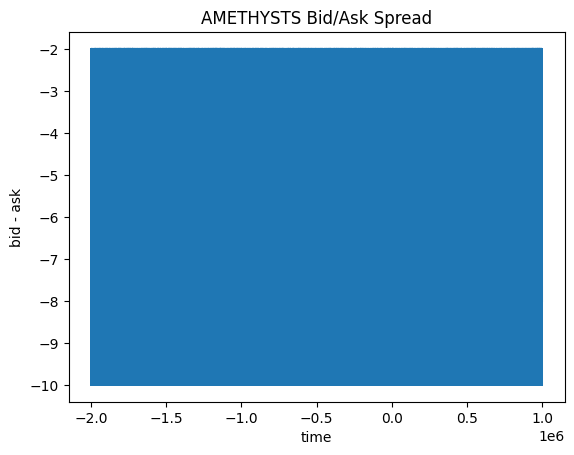

STARFRUIT: mean spread = -5.3996
STARFRUIT: median spread = -5.3996


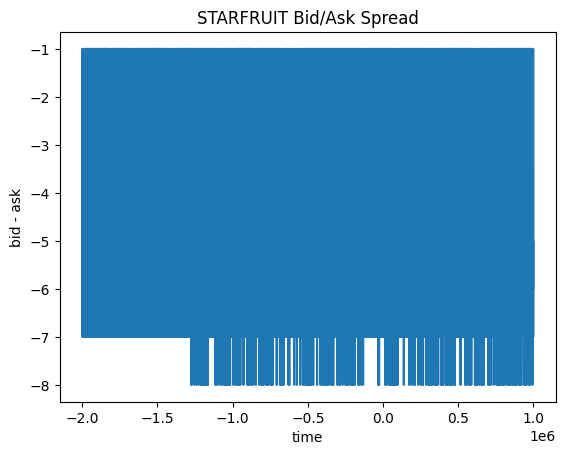

In [14]:
for x in quotes_products:
    # Create the plot
    spread = quotes.loc[x]['bid_price_1'] - quotes.loc[x]['ask_price_1']

    spread_mean = spread.mean()
    spread_median = spread.mean()

    plt.plot(quotes.loc[x].index, spread)

    # Title and labels
    plt.title(f'{x} Bid/Ask Spread')
    plt.xlabel('time')
    plt.ylabel('bid - ask')

    print(f'{x}: mean spread = {spread_mean}')
    print(f'{x}: median spread = {spread_median}')
    # Display the plot
    plt.show()

### Plot the price graphs
Check the trends

AMETHYSTS volatility = 21.121


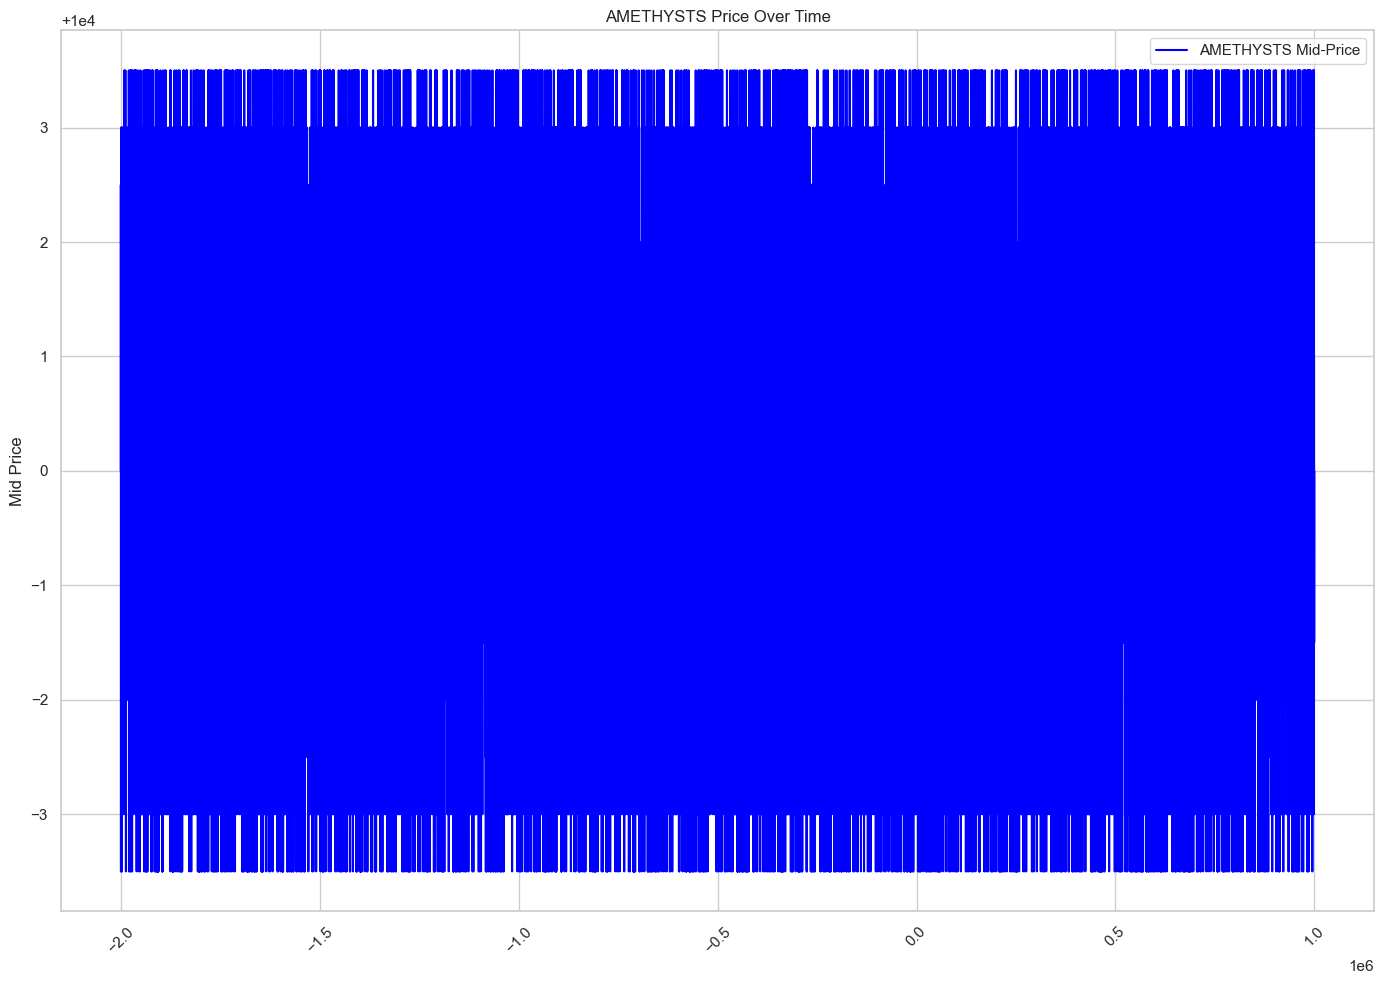

STARFRUIT volatility = 33.65


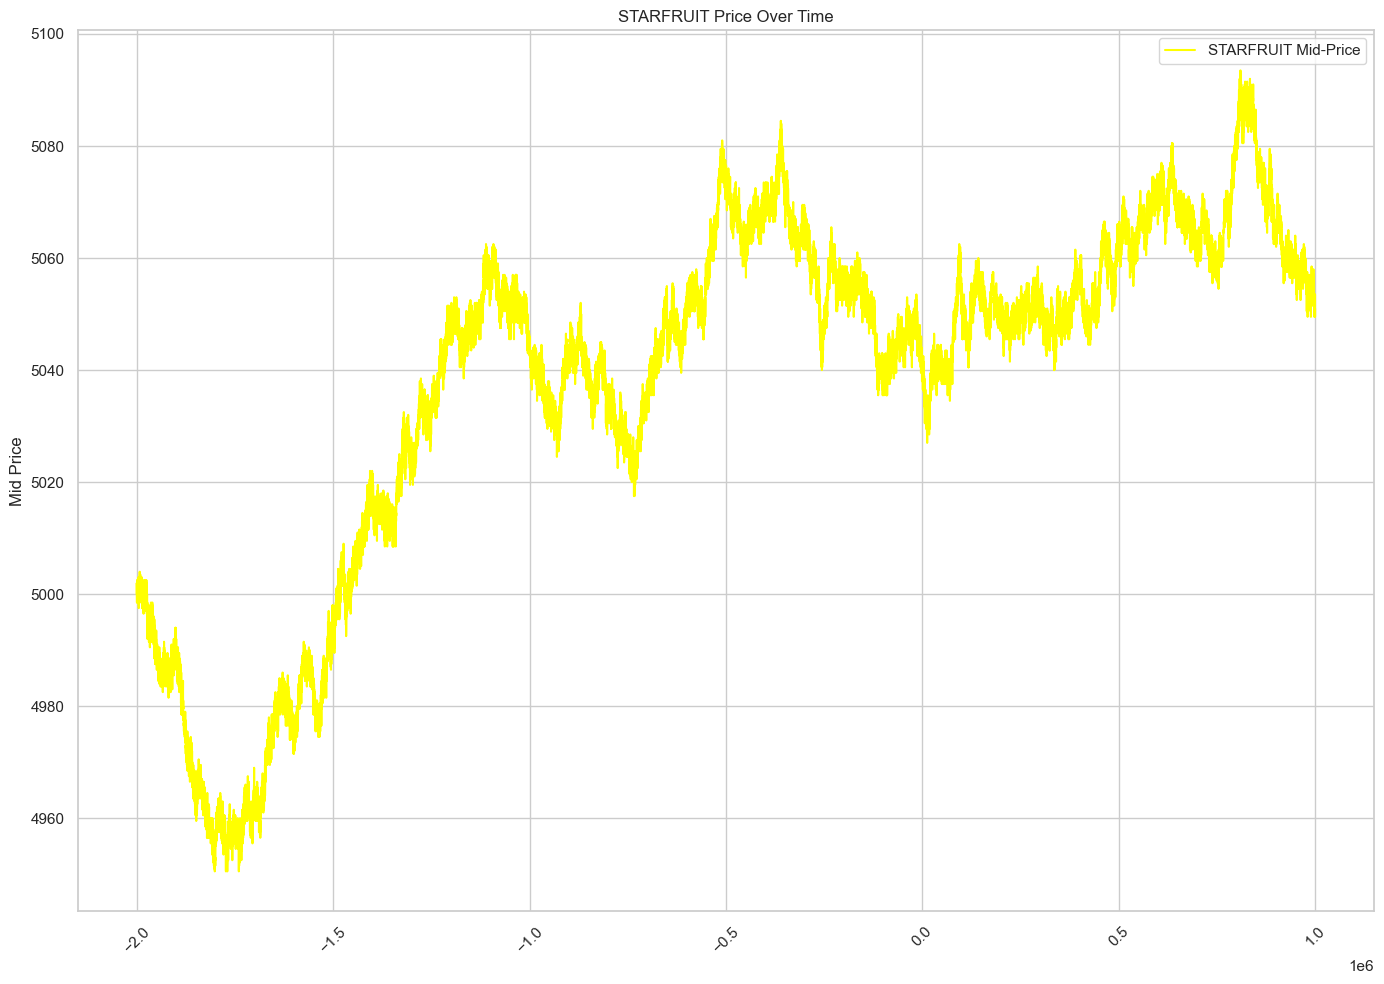

In [15]:
for x in quotes_products:
    # Set the Seaborn theme for better aesthetics
    sns.set_theme(style="whitegrid")

    # Colors for the plots
    colors = {
        'AMETHYSTS': 'blue',
        'STARFRUIT': 'yellow',
        'BANANAS': 'yellow',
        'BERRIES': 'red',
        'COCONUTS': 'brown',
        'DIVING_GEAR': 'blue',
        'DOLPHIN_SIGHTINGS': 'yellow',
        'PEARLS': 'brown',
        'PINA_COLADAS': 'brown',
    }

    rets_vol = quotes.loc[x, 'rets'].std() * 10e4
    print(f'{x} volatility = {round(rets_vol,3)}')

    # Plotting ETH/USD Mid Price
    plt.figure(figsize=(14, 10))  # Create a new figure for ETH/USD
    plt.plot(quotes.loc[x].index, quotes.loc[x]['mid_price'], label= f'{x} Mid-Price', color=colors[f'{x}'])
    plt.title(f'{x} Price Over Time')
    plt.ylabel('Mid Price')
    plt.legend()
    plt.xticks(rotation=45)
    #plt.yticks(range(int(min(quotes.loc[x]['mid_price'])), int(max(quotes.loc[x]['mid_price'])) + 1, 10))
    plt.tight_layout()
    plt.show()

## Plot trades history

AMETHYSTS Volume volatility = 2.481967730663525


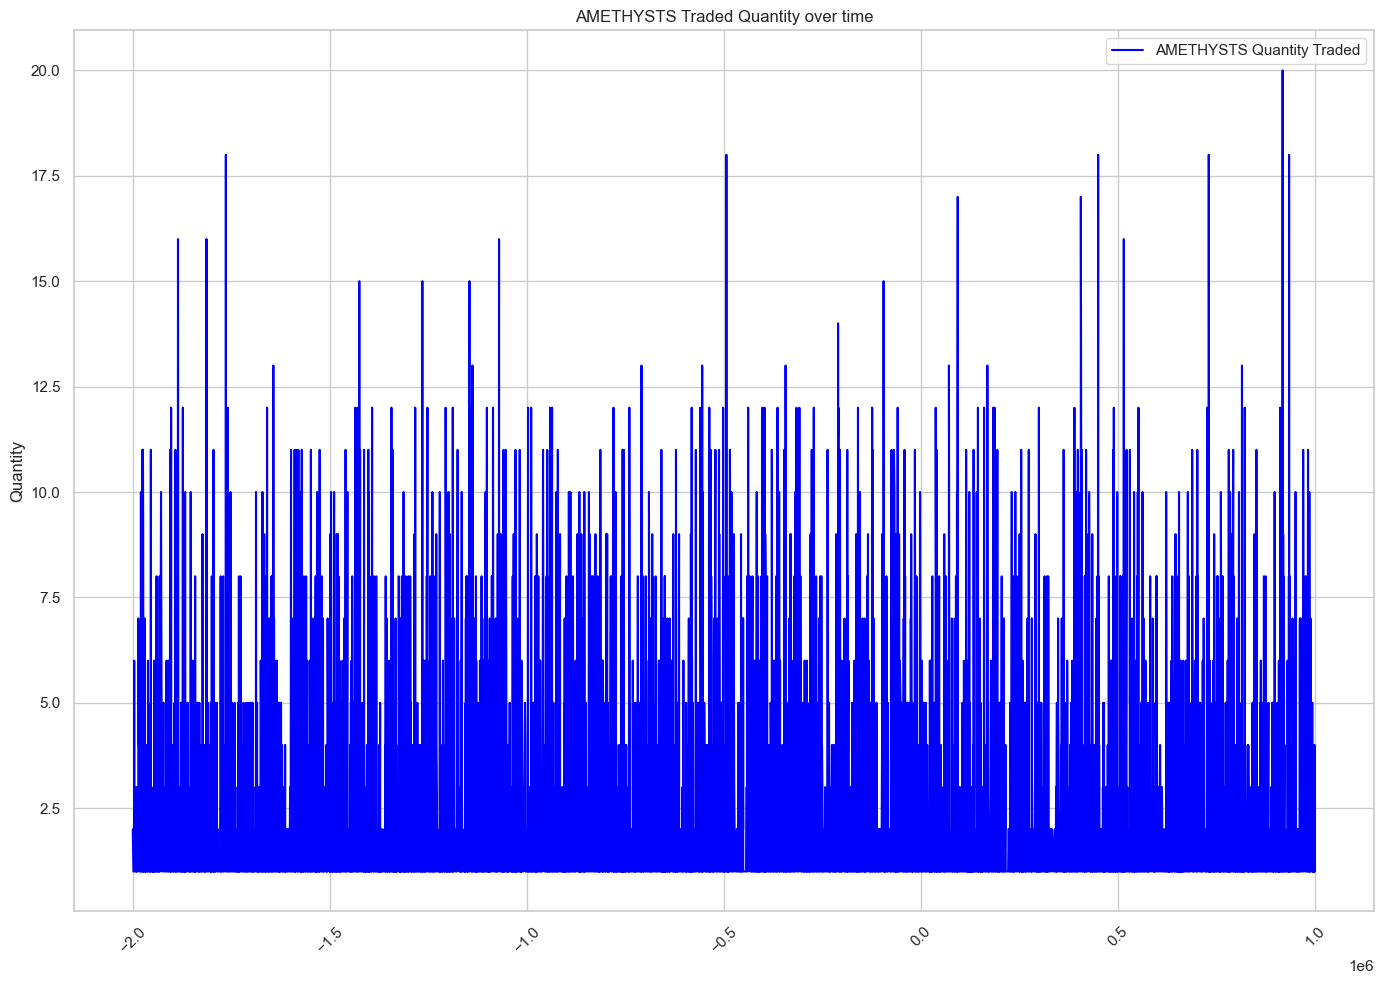

STARFRUIT Volume volatility = 3.7633639868105924


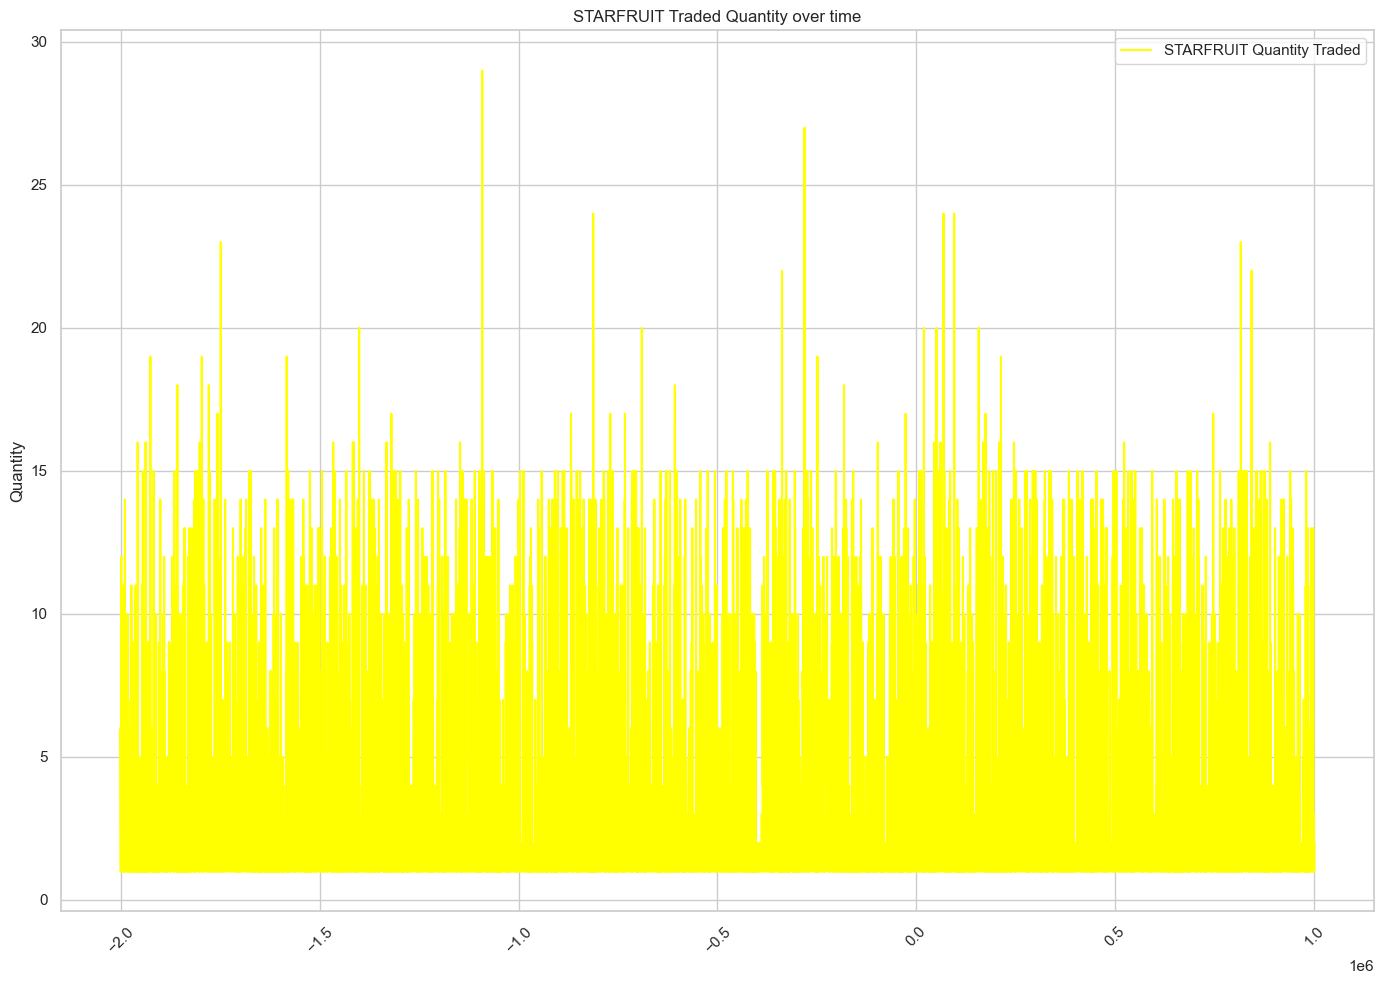

In [16]:
for x in trades_symbols:
    # Set the Seaborn theme for better aesthetics
    sns.set_theme(style="whitegrid")

    # Colors for the plots
    colors = {
        'AMETHYSTS': 'blue',
        'STARFRUIT': 'yellow',
        'BANANAS': 'yellow',
        'BERRIES': 'red',
        'COCONUTS': 'brown',
        'DIVING_GEAR': 'blue',
        'DOLPHIN_SIGHTINGS': 'yellow',
        'PEARLS': 'brown',
        'PINA_COLADAS': 'brown',
    }

    volume_vol = trades.loc[x, 'quantity'].std()
    print(f'{x} Volume volatility = {volume_vol}')

    plt.figure(figsize=(14, 10)) 
    plt.plot(trades.loc[x].index, trades.loc[x]['quantity'], label= f'{x} Quantity Traded', color=colors[f'{x}'])
    plt.title(f'{x} Traded Quantity over time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.xticks(rotation=45)
    #plt.yticks(range(int(min(quotes.loc[x]['mid_price'])), int(max(quotes.loc[x]['mid_price'])) + 1, 10))
    plt.tight_layout()
    plt.show()

### Check the correlation of returns across products

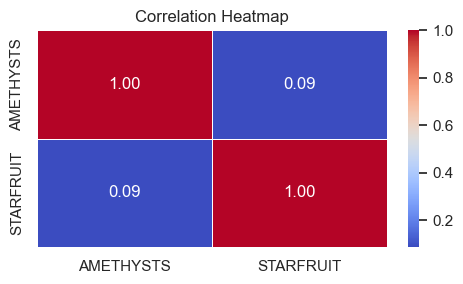

In [17]:
series = pd.DataFrame(columns = quotes_products)
 
for x in quotes_products:
    series[x] = quotes.loc[x]['rets']

# Calculate correlation
correlation_matrix = series.corr()

# Plotting the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')

# Adjusting aspect ratio to ensure all elements are properly displayed
plt.tight_layout()

plt.show()

## Use mid-price as the MKT Theo - Solve the objective function based on derivation?

In [18]:
quotes['MKT_Theo'] = quotes['mid_price']


## Calculate Features to predict the MKT %

### Calculate Smoothed Volume - Smoothed Quantity

In [19]:
def calc_abs_volume(df, quantity_alpha = 0.5):
    """
    Apply Exponential smoothing with an alpha to the absolute value of the volume
    """
    df['quantity_smth'] = df['quantity_adj'].abs().ewm(alpha=quantity_alpha, ignore_na=True).mean()
    df['quantity_smth'].fillna(0, inplace=True)

    return df

In [20]:
# Group by the first level of the multi-index (assuming product is the first level)
grouped = trades.groupby(level=0)

# Apply calc_abs_volume function to each group
smoothed_groups = [calc_abs_volume(group) for _, group in grouped]

# Concatenate the smoothed groups back into a single DataFrame
smoothed_trades = pd.concat(smoothed_groups)
trades = smoothed_trades

### Quick - Raw Volume Analysis - STARFRUIT is more liquid then AMETHYSTS

In [21]:
# Check the sum, mean and standard deviation of the raw volume
for _ in trades_symbols:
    if _ != "DOLPHIN_SIGHTINGS":
        std = trades.loc[_]['quantity'].std()
        sum = trades.loc[_]['quantity'].sum()
        mean = trades.loc[_]['quantity'].mean()
        print(f'{_} sum volume = {sum}')
        print(f'{_} mean volume = {mean}')
        print(f'{_} std dev volume = {std}\n')

AMETHYSTS sum volume = 15227.0
AMETHYSTS mean volume = 2.4476772223115253
AMETHYSTS std dev volume = 2.481967730663525

STARFRUIT sum volume = 24996.0
STARFRUIT mean volume = 3.2290401756878957
STARFRUIT std dev volume = 3.7633639868105924



### Quick - Raw Flow Analysis - - STARFRUIT and AMETHYSTS have more buys then sells

In [22]:
# Check the sum of the buys and sells
for _ in trades_symbols:
    if _ != "DOLPHIN_SIGHTINGS":
        sum = trades.loc[_]['quantity_adj'].sum()
        print(f'{_} raw volume direction = {sum}')

AMETHYSTS raw volume direction = 2253.0
STARFRUIT raw volume direction = 5444.0


### Calculate Trade Flow

In [23]:
def calc_trade_flow(df, quantity_alpha = 0.5):
    """
    Apply Exponential smoothing with an alpha to the volume itself
    """
    df['trade_flow'] = df['quantity_adj'].ewm(alpha=quantity_alpha, ignore_na=True).mean()
    df['trade_flow'].fillna(0, inplace=True)

    return df

In [24]:
# Group by the first level of the multi-index (assuming product is the first level)
grouped = trades.groupby(level=0)

# Apply calc_trade_flow function to each group
smoothed_groups = [calc_trade_flow(group) for _, group in grouped]

# Concatenate the smoothed groups back into a single DataFrame
smoothed_trades = pd.concat(smoothed_groups)
trades = smoothed_trades

In [25]:
trades.head()

currency  quantity    price  bid_price_1  ask_price_1  \
symbol    timestamp                                                            
AMETHYSTS -2000000.0  SEASHELLS       2.0   9996.0       9996.0      10004.0   
          -1998500.0  SEASHELLS       1.0  10004.0       9996.0      10004.0   
          -1997500.0  SEASHELLS       1.0   9998.0       9995.0       9998.0   
          -1996800.0  SEASHELLS       1.0   9996.0       9996.0      10004.0   
          -1996700.0  SEASHELLS       2.0   9995.0       9995.0      10005.0   

                      quantity_adj  quantity_smth  trade_flow  
symbol    timestamp                                            
AMETHYSTS -2000000.0           2.0       2.000000    2.000000  
          -1998500.0          -1.0       1.333333    0.000000  
          -1997500.0          -1.0       1.142857   -0.571429  
          -1996800.0           1.0       1.066667    0.266667  
          -1996700.0           2.0       1.548387    1.161290

### Calculate Share Imbalance

In [26]:
def calculate_share_imbalance(df):
    """
    Adds a 'share_imbalance' column to the DataFrame based on the formula:
    bid_volume_1 / (bid_volume_1 + ask_volume_1)
    
    Parameters:
    - df: pandas DataFrame with columns 'bid_size_1' and 'ask_size_1'
    
    Returns:
    - DataFrame with an additional 'share_imbalance' column
    """
    # Calculate the share imbalance
    df['share_imbalance'] = df['bid_volume_1'] / (df['bid_volume_1'] + df['ask_volume_1'])
    

In [27]:
calculate_share_imbalance(quotes)
quotes.tail()

bid_price_1  ask_price_1  bid_price_2  ask_price_2  \
product   timestamp                                                       
STARFRUIT 999500.0        5049.0       5056.0          0.0          0.0   
          999600.0        5048.0       5054.0       5047.0          0.0   
          999700.0        5053.0       5054.0       5048.0       5055.0   
          999800.0        5047.0       5052.0          0.0       5054.0   
          999900.0        5048.0       5054.0       5047.0          0.0   

                     bid_price_3  ask_price_3  bid_volume_1  ask_volume_1  \
product   timestamp                                                         
STARFRUIT 999500.0           0.0          0.0          28.0          28.0   
          999600.0           0.0          0.0           9.0          29.0   
          999700.0           0.0          0.0           1.0           2.0   
          999800.0           0.0          0.0          27.0           1.0   
          999900.0           0.0          0.0           2.0          23.0   

                     bid_volume_2  ask_volume_2  bid_volume_3  ask_volume_3  \
product   timestamp                                                           
STARFRUIT 999500.0            0.0           0.0           0.0           0.0   
          999600.0           27.0           0.0           0.0           0.0   
          999700.0           26.0          24.0           0.0           0.0   
          999800.0            0.0          27.0           0.0           0.0   
          999900.0           21.0           0.0           0.0           0.0   

                     mid_price      rets  MKT_Theo  share_imbalance  
product   timestamp                                                  
STARFRUIT 999500.0      5052.5  0.000198    5052.5         0.500000  
          999600.0      5051.0 -0.000297    5051.0         0.236842  
          999700.0      5053.5  0.000495    5053.5         0.333333  
          999800.0      5049.5 -0.000792    5049.5         0.964286  
          999900.0      5051.0  0.000297    5051.0         0.080000

### Join the smoothed quantity and trade flow from trades with the share imbalance in quotes. Fill NaN with 0

In [28]:
trades_quantity_flow = trades[['quantity_smth', 'trade_flow']]

# Change the name of the indices so that join does not produce new indices
trades_quantity_flow.rename_axis(['product', 'timestamp'], inplace=True)

quotes = quotes.join(trades_quantity_flow, how='left')
quotes.fillna(0, inplace=True)

# Check for null values
quantity_smth_null = quotes['quantity_smth'].isna().sum()
trade_flow_null = quotes['trade_flow'].isna().sum()
print(f'Number of null values in smoothed quantity: {quantity_smth_null}')
print(f'Number of null values in trade flow: {trade_flow_null}')

Number of null values in smoothed quantity: 0
Number of null values in trade flow: 0


In [29]:
## Check for the duplicate index in quotes
for col in quotes_products:
    duplicated_rows = quotes.loc[col].index.duplicated()
    print(f'{col} - duplicate index in the orderbook: {duplicated_rows.sum()} ')

AMETHYSTS - duplicate index in the orderbook: 0 
STARFRUIT - duplicate index in the orderbook: 0 


In [30]:
quotes.head()

bid_price_1  ask_price_1  bid_price_2  ask_price_2  \
product   timestamp                                                        
AMETHYSTS -2000000.0       9996.0      10004.0       9995.0      10005.0   
          -1999900.0      10000.0      10005.0       9995.0          0.0   
          -1999800.0       9996.0      10004.0       9995.0      10005.0   
          -1999700.0       9996.0      10004.0       9995.0      10005.0   
          -1999600.0       9995.0       9998.0          0.0      10002.0   

                      bid_price_3  ask_price_3  bid_volume_1  ask_volume_1  \
product   timestamp                                                          
AMETHYSTS -2000000.0          0.0          0.0           1.0           1.0   
          -1999900.0          0.0          0.0           5.0          20.0   
          -1999800.0          0.0          0.0           1.0           1.0   
          -1999700.0          0.0          0.0           1.0           1.0   
          -1999600.0          0.0      10005.0          20.0           3.0   

                      bid_volume_2  ask_volume_2  bid_volume_3  ask_volume_3  \
product   timestamp                                                            
AMETHYSTS -2000000.0          25.0          25.0           0.0           0.0   
          -1999900.0          20.0           0.0           0.0           0.0   
          -1999800.0          30.0          30.0           0.0           0.0   
          -1999700.0          26.0          26.0           0.0           0.0   
          -1999600.0           0.0           9.0           0.0          20.0   

                      mid_price     rets  MKT_Theo  share_imbalance  \
product   timestamp                                                   
AMETHYSTS -2000000.0    10000.0  0.00000   10000.0         0.500000   
          -1999900.0    10002.5  0.00025   10002.5         0.200000   
          -1999800.0    10000.0 -0.00025   10000.0         0.500000   
          -1999700.0    10000.0  0.00000   10000.0         0.500000   
          -1999600.0     9996.5 -0.00035    9996.5         0.869565   

                      quantity_smth  trade_flow  
product   timestamp                              
AMETHYSTS -2000000.0            2.0         2.0  
          -1999900.0            0.0         0.0  
          -1999800.0            0.0         0.0  
          -1999700.0            0.0         0.0  
          -1999600.0            0.0         0.0

### Add % change of MKT_Theo and mid_price - a new index column is added??

In [31]:
# Define a function to shift columns and remove the final row of each subgroup

def shift_and_remove_last(group):
    group['MKT_Theo_%_lead1'] = group['MKT_Theo_%'].shift(-1)
    return group.iloc[:-1]  # Remove the final row of each subgroup


quotes['MKT_Theo_%'] = quotes['MKT_Theo'].pct_change()

# Apply the function to each subgroup defined by the MultiIndex
quotes = quotes.groupby(level=0).apply(shift_and_remove_last)

quotes.head()

bid_price_1  ask_price_1  bid_price_2  \
product   product   timestamp                                           
AMETHYSTS AMETHYSTS -2000000.0       9996.0      10004.0       9995.0   
                    -1999900.0      10000.0      10005.0       9995.0   
                    -1999800.0       9996.0      10004.0       9995.0   
                    -1999700.0       9996.0      10004.0       9995.0   
                    -1999600.0       9995.0       9998.0          0.0   

                                ask_price_2  bid_price_3  ask_price_3  \
product   product   timestamp                                           
AMETHYSTS AMETHYSTS -2000000.0      10005.0          0.0          0.0   
                    -1999900.0          0.0          0.0          0.0   
                    -1999800.0      10005.0          0.0          0.0   
                    -1999700.0      10005.0          0.0          0.0   
                    -1999600.0      10002.0          0.0      10005.0   

                                bid_volume_1  ask_volume_1  bid_volume_2  \
product   product   timestamp                                              
AMETHYSTS AMETHYSTS -2000000.0           1.0           1.0          25.0   
                    -1999900.0           5.0          20.0          20.0   
                    -1999800.0           1.0           1.0          30.0   
                    -1999700.0           1.0           1.0          26.0   
                    -1999600.0          20.0           3.0           0.0   

                                ask_volume_2  bid_volume_3  ask_volume_3  \
product   product   timestamp                                              
AMETHYSTS AMETHYSTS -2000000.0          25.0           0.0           0.0   
                    -1999900.0           0.0           0.0           0.0   
                    -1999800.0          30.0           0.0           0.0   
                    -1999700.0          26.0           0.0           0.0   
                    -1999600.0           9.0           0.0          20.0   

                                mid_price     rets  MKT_Theo  share_imbalance  \
product   product   timestamp                                                   
AMETHYSTS AMETHYSTS -2000000.0    10000.0  0.00000   10000.0         0.500000   
                    -1999900.0    10002.5  0.00025   10002.5         0.200000   
                    -1999800.0    10000.0 -0.00025   10000.0         0.500000   
                    -1999700.0    10000.0  0.00000   10000.0         0.500000   
                    -1999600.0     9996.5 -0.00035    9996.5         0.869565   

                                quantity_smth  trade_flow  MKT_Theo_%  \
product   product   timestamp                                           
AMETHYSTS AMETHYSTS -2000000.0            2.0         2.0         NaN   
                    -1999900.0            0.0         0.0     0.00025   
                    -1999800.0            0.0         0.0    -0.00025   
                    -1999700.0            0.0         0.0     0.00000   
                    -1999600.0            0.0         0.0    -0.00035   

                                MKT_Theo_%_lead1  
product   product   timestamp                     
AMETHYSTS AMETHYSTS -2000000.0           0.00025  
                    -1999900.0          -0.00025  
                    -1999800.0           0.00000  
                    -1999700.0          -0.00035  
                    -1999600.0           0.00035

## Build a Regression Model to predict MKT_Theo % for the next tick

In [32]:
# Build a linear regression model - We use the summary function to return all the stats of the model fit

def calc_reg(y, X, intercept=True, printout = True):
    """
    [0.025, 0.975] represents the 95% confidence interval for the coefficient and intercept estimates. Out of this range is considered outlier
    """
    if intercept:
        X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    model_res = model.fit()

    inter = model_res.params[0] if intercept else None
    betas = model_res.params[1:] if intercept else model_res.params

    #rsquared = model_res.rsquared

    res_dict = {'intercept': inter, 'beta(s)': betas}

    if printout:
        print(model_res.summary())
    return model_res

## Regression Result: Add MKT_Theo_% to AMETHYSTS but keep it out for STARFRUIT

In [33]:
# Build a ordinary least squares regression - HARD CODE THE WEIGHTS FOR THE PRODUCTION CODE

weights_dict = {}
MKT_change_dict = {}
for x in quotes_products:
    print(f'{x} regression started')
    if x!= "DOLPHIN_SIGHTINGS":
        quotes_temp = quotes.loc[x].reset_index()
        X = quotes_temp[['quantity_smth','trade_flow', 'share_imbalance']]
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y = quotes_temp[['MKT_Theo_%_lead1']]
        weights = np.linalg.inv(X.T @ X) @ X.T @ y
        weights_dict[x] = weights
        MKT_change_dict[x] = X @ weights

        #model_res = calc_reg(y, X)
        #weights_dict[x] = model_res.params
        #X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        #MKT_change_dict[x] = model_res.predict(X)
    
    # Put a placeholder for DOLPHIN_SIGHTINGS 
    else:
        quotes_temp = quotes.loc[x].reset_index()
        X = quotes_temp[['quantity_smth','trade_flow', 'share_imbalance']]
        MKT_change_dict[x] = np.ones((X.shape[0], 1))
    
    print(f'{x} regression completed')


# Combine the predictions and write in the quotes
MKT_change_pred = np.vstack(list(MKT_change_dict.values()))
quotes['MKT_Theo_%_Pred'] = MKT_change_pred


AMETHYSTS regression started
AMETHYSTS regression completed
STARFRUIT regression started
STARFRUIT regression completed


In [34]:
for x in quotes_products:

    max_pred = abs(quotes.loc[x]['MKT_Theo_%_Pred']).max()
    min_pred = abs(quotes.loc[x]['MKT_Theo_%_Pred']).min()
    mean_pred = abs(quotes.loc[x]['MKT_Theo_%_Pred']).mean()
    print(f'{x} - Max % change predictio {max_pred}')
    print(f'{x} - Min % change predictio {min_pred}')
    print(f'{x} - Mean % change predictio {mean_pred}')

AMETHYSTS - Max % change predictio 0.0003187857544759808
AMETHYSTS - Min % change predictio 4.746022251162472e-08
AMETHYSTS - Mean % change predictio 2.7946234420955805e-05
STARFRUIT - Max % change predictio 0.00042435925727578295
STARFRUIT - Min % change predictio 3.1918486620473654e-08
STARFRUIT - Mean % change predictio 0.00011485813011263405


In [35]:
quotes.head()

bid_price_1  ask_price_1  bid_price_2  \
product   product   timestamp                                           
AMETHYSTS AMETHYSTS -2000000.0       9996.0      10004.0       9995.0   
                    -1999900.0      10000.0      10005.0       9995.0   
                    -1999800.0       9996.0      10004.0       9995.0   
                    -1999700.0       9996.0      10004.0       9995.0   
                    -1999600.0       9995.0       9998.0          0.0   

                                ask_price_2  bid_price_3  ask_price_3  \
product   product   timestamp                                           
AMETHYSTS AMETHYSTS -2000000.0      10005.0          0.0          0.0   
                    -1999900.0          0.0          0.0          0.0   
                    -1999800.0      10005.0          0.0          0.0   
                    -1999700.0      10005.0          0.0          0.0   
                    -1999600.0      10002.0          0.0      10005.0   

                                bid_volume_1  ask_volume_1  bid_volume_2  \
product   product   timestamp                                              
AMETHYSTS AMETHYSTS -2000000.0           1.0           1.0          25.0   
                    -1999900.0           5.0          20.0          20.0   
                    -1999800.0           1.0           1.0          30.0   
                    -1999700.0           1.0           1.0          26.0   
                    -1999600.0          20.0           3.0           0.0   

                                ask_volume_2  ...  ask_volume_3  mid_price  \
product   product   timestamp                 ...                            
AMETHYSTS AMETHYSTS -2000000.0          25.0  ...           0.0    10000.0   
                    -1999900.0           0.0  ...           0.0    10002.5   
                    -1999800.0          30.0  ...           0.0    10000.0   
                    -1999700.0          26.0  ...           0.0    10000.0   
                    -1999600.0           9.0  ...          20.0     9996.5   

                                   rets  MKT_Theo  share_imbalance  \
product   product   timestamp                                        
AMETHYSTS AMETHYSTS -2000000.0  0.00000   10000.0         0.500000   
                    -1999900.0  0.00025   10002.5         0.200000   
                    -1999800.0 -0.00025   10000.0         0.500000   
                    -1999700.0  0.00000   10000.0         0.500000   
                    -1999600.0 -0.00035    9996.5         0.869565   

                                quantity_smth  trade_flow  MKT_Theo_%  \
product   product   timestamp                                           
AMETHYSTS AMETHYSTS -2000000.0            2.0         2.0         NaN   
                    -1999900.0            0.0         0.0     0.00025   
                    -1999800.0            0.0         0.0    -0.00025   
                    -1999700.0            0.0         0.0     0.00000   
                    -1999600.0            0.0         0.0    -0.00035   

                                MKT_Theo_%_lead1  MKT_Theo_%_Pred  
product   product   timestamp                                      
AMETHYSTS AMETHYSTS -2000000.0           0.00025    -5.643007e-05  
                    -1999900.0          -0.00025    -5.120085e-05  
                    -1999800.0           0.00000     2.473054e-07  
                    -1999700.0          -0.00035     2.473054e-07  
                    -1999600.0           0.00035     6.362546e-05  

[5 rows x 21 columns]

In [36]:
quotes.to_csv('quotes_final_2024.csv')
trades.to_csv('trades_final_2024.csv')